# Baseline  


In [1]:
from pycaret.regression import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss,mean_absolute_error
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 한글 깨짐
import platform
if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': #윈도우
        plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': #리눅스 (구글 콜랩)
        #!wget "https://www.wfonts.com/download/data/2016/06/13/malgun-gothic/malgun.ttf"
        #!mv malgun.ttf /usr/share/fonts/truetype/
        #import matplotlib.font_manager as fm 
        #fm._rebuild() 
        plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [98]:
train_raw = pd.read_csv('train.csv',encoding = 'utf-8')
test_raw = pd.read_csv('test.csv',encoding = 'utf-8')
train = train_raw
test = test_raw

In [14]:
holiday = pd.read_csv('holiday.csv',encoding = 'utf-8')

In [15]:
#메뉴는 일단 제외
drops = ['조식메뉴', '중식메뉴', '석식메뉴']

train = train.drop(drops, axis=1)
test = test.drop(drops, axis=1)

In [5]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   중식계             1205 non-null   float64
 8   석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 84.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가

In [7]:
#train.describe
print(train.isnull().sum())
print(test.isnull().sum())

일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
중식계               0
석식계               0
dtype: int64
일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
dtype: int64


In [99]:
#날짜 전처리;
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train['year'] = train['일자'].dt.year
train['month'] = train['일자'].dt.month
train['week'] = train['일자'].dt.week
train['day'] = train['일자'].dt.day

test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['week'] = test['일자'].dt.week
test['day'] = test['일자'].dt.day

In [100]:
#holiday join
holiday['요일'] = holiday['요일'].str[0]
holiday.rename(columns ={
    '명칭':'명칭','날짜':'일자','요일':'요일'},inplace = True)
holiday.head(20)

,명칭,일자,요일
0,신정,20160101,금
1,설날,20160207,일
2,설날,20160208,월
3,설날,20160209,화
4,대체공휴일,20160210,수
5,삼일절,20160301,화
6,국회의원선거일,20160413,수
7,어린이날,20160505,목
8,석가탄신일,20160514,토
9,현충일,20160606,월


In [16]:
#pd.to_datetime input 인자 str
holiday['일자'] = pd.to_datetime(holiday['일자'].astype('str'))
#holiday.head()
#holiday.info()

In [20]:
train.일자.head(30)

0    2016-02-01
1    2016-02-02
2    2016-02-03
3    2016-02-04
4    2016-02-05
5    2016-02-11
6    2016-02-12
7    2016-02-15
8    2016-02-16
9    2016-02-17
10   2016-02-18
11   2016-02-19
12   2016-02-22
13   2016-02-23
14   2016-02-24
15   2016-02-25
16   2016-02-26
17   2016-02-29
18   2016-03-02
19   2016-03-03
20   2016-03-04
21   2016-03-07
22   2016-03-08
23   2016-03-09
24   2016-03-10
25   2016-03-11
26   2016-03-14
27   2016-03-15
28   2016-03-16
29   2016-03-17
Name: 일자, dtype: datetime64[ns]

In [17]:
holiday_list = holiday['일자']
af_holiday = holiday_list.map(lambda x:x+dt.timedelta(days=1))
bf_holiday = holiday_list.map(lambda x:x-dt.timedelta(days=1))  
ab_holiday = [af_holiday,bf_holiday]
ab_holiday

[0     2016-01-02
 1     2016-02-08
 2     2016-02-09
 3     2016-02-10
 4     2016-02-11
 5     2016-03-02
 6     2016-04-14
 7     2016-05-06
 8     2016-05-15
 9     2016-06-07
 10    2016-08-16
 11    2016-09-15
 12    2016-09-16
 13    2016-09-17
 14    2016-10-04
 15    2016-10-10
 16    2016-12-26
 17    2017-01-02
 18    2017-01-28
 19    2017-01-29
 20    2017-01-30
 21    2017-01-31
 22    2017-03-02
 23    2017-05-04
 24    2017-05-06
 25    2017-05-10
 26    2017-06-07
 27    2017-08-16
 28    2017-10-03
 29    2017-10-04
 30    2017-10-04
 31    2017-10-05
 32    2017-10-06
 33    2017-10-07
 34    2017-10-10
 35    2017-12-26
 36    2018-01-02
 37    2018-02-16
 38    2018-02-17
 39    2018-02-18
 40    2018-03-02
 41    2018-05-06
 42    2018-05-08
 43    2018-05-23
 44    2018-06-07
 45    2018-06-14
 46    2018-08-16
 47    2018-09-24
 48    2018-09-25
 49    2018-09-26
 50    2018-09-27
 51    2018-10-04
 52    2018-10-10
 53    2018-12-26
 54    2019-01-02
 55    201

In [24]:
#왜 겹치는 날 있는데 1안나오니?
for i in range(0,len(train)-1):
    if train['일자'][i] in [af_holiday.item]:
        print(1)

In [29]:
train['일자'][0]
af_holiday[1]

Timestamp('2016-02-08 00:00:00')

In [25]:
a = train['일자'].apply(lambda x: 1 if x in [af_holiday.item,bf_holiday.item] else 0)
a.sum()

0

# Holiday 전후 1일 레이블링하여 left join from R

In [30]:
#R에서 전처리해서 Is_holiday 가져오기
Is_holiday = pd.read_csv('Is_holiday.csv',encoding = 'utf-8')
Is_holiday.Is_holiday.sum()
#78개의 1인 행 존재
Is_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   일자          1255 non-null   object
 1   Is_holiday  1255 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 19.7+ KB


In [31]:
Is_holiday['일자'] = pd.to_datetime(Is_holiday['일자'])

In [86]:
#left join on '일자'
train = pd.merge(train,Is_holiday, left_on='일자', right_on='일자', how='left')
test = pd.merge(test,Is_holiday,left_on = '일자', right_on='일자', how ='left')

In [101]:
#요일 라벨 인코딩
weekday = {
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}

train['요일'] = train['요일'].map(weekday)
test['요일'] = test['요일'].map(weekday)

#내부근무자수 생성
train['내부근무자수'] = train['본사정원수']-train['본사휴가자수']-train['본사출장자수']-train['현본사소속재택근무자수']
test['내부근무자수'] = test['본사정원수']-test['본사휴가자수']-test['본사출장자수']-test['현본사소속재택근무자수']
#식수가능인원!=내부근무자수 : 본사출장자수는 중식먹고 오후에 출장을 갈 수 있다는 가정. 이후 확인 필요함
#train['식수가능인원'] = train['본사정원수']-train['본사휴가자수']-train['현본사소속재택근무자수']
#test['식수가능인원'] = test['본사정원수']-test['본사휴가자수']-test['현본사소속재택근무자수']

In [102]:
#석식계 요일 rank_labeling
weekday_rank4dinner = {
    1: 1,
    2: 2,
    3: 5,
    4: 3,
    5: 4,
}

train['요일(석식)'] = train['요일'].map(weekday_rank4dinner)
test['요일(석식)'] = test['요일'].map(weekday_rank4dinner)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식계             1205 non-null   float64       
 8   석식계             1205 non-null   float64       
 9   year            1205 non-null   int64         
 10  month           1205 non-null   int64         
 11  week            1205 non-null   int64         
 12  day             1205 non-null   int64         
 13  내부근무자수          1205 non-null   float64       
 14  요일(석식)          1205 non-null   int64         
dtypes: d

<AxesSubplot:>

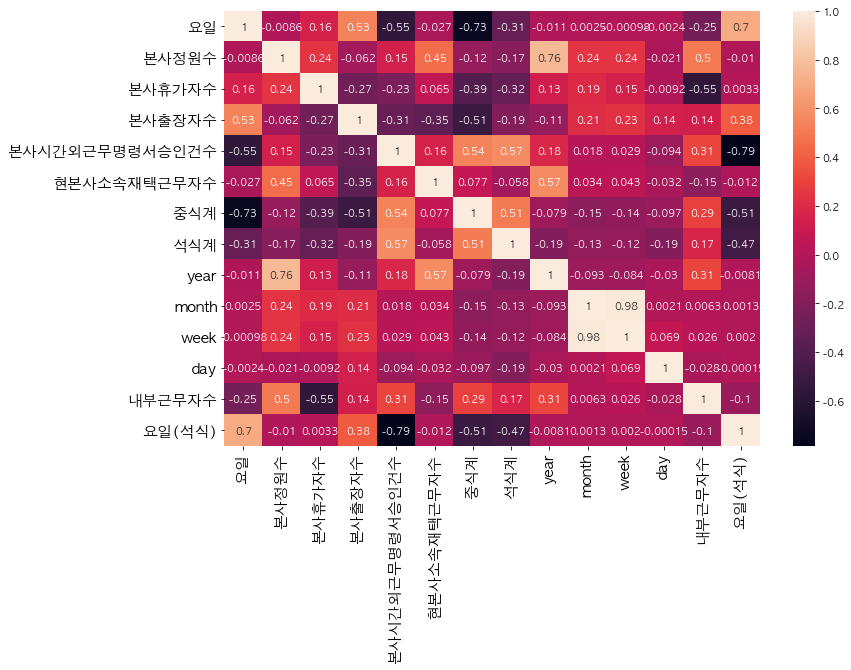

In [19]:
#상관관계 분석
plt.figure(figsize = (12,8))
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.heatmap(train.corr(), annot = True)
#중식계와 유의미한 변수 : 요일, 본사시간외근무명령서승인건수(야근),본사출장자수/석식계 ,본사휴가자수 
#석식계와 유의미한 변수 : 본사시간외근무명령서승인건수, 중식계, 본사휴가자수 

<AxesSubplot:>

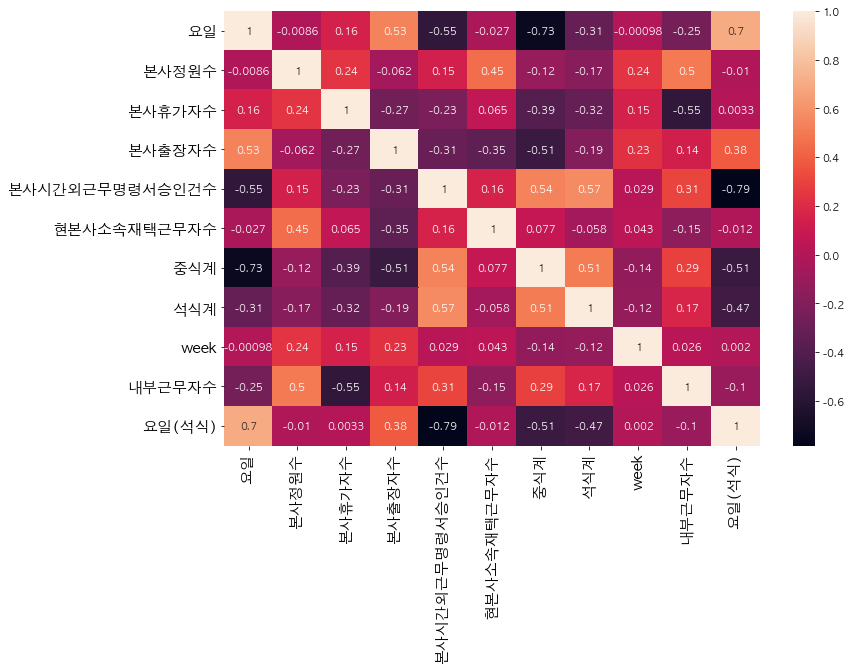

In [20]:
#요일 제외 유의미하지 않으니 year,month,day제외하고 heatmap
plt.figure(figsize = (12,8))
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.heatmap(train.drop(['year','month','day'],axis = 1).corr(),annot = True)

- 시각화 결과 2020년 4월 이후 일정기간 중석식계 모두 감소가 있었다. 그 이유는 무엇일까?  
    가장 큰 예상 이유는 코로나이다. but, 코로나가 어떻게 본사에 영향을 주었는지는 추후에 판단이 필요하다
    - 예상1) 내부근무자수 감소(= 출장자 + 휴가자수 증가 or 재택근무자수 증가)
    - 예상2) 본사 정원수 감소

# 토픽모델링 적용

In [103]:
train_tp = pd.read_csv('train_topic.csv',encoding = 'cp949')
test_tp = pd.read_csv('test_topic.csv',encoding = 'cp949')

In [104]:
train_tp = train_tp[['Topic1','Topic2','Topic3','Topic4','일자']]
test_tp = test_tp[['Topic1','Topic2','Topic3','Topic4','일자']]

In [105]:
train_tp['일자'] = pd.to_datetime(train_tp['일자'])
test_tp['일자'] = pd.to_datetime(test_tp['일자'])

In [106]:
train =pd.merge(train,train_tp, left_on='일자', right_on='일자', how='left')
test = pd.merge(test,test_tp,left_on = '일자', right_on='일자', how ='left')

In [107]:
#Topic 변수 na값은 0으로 대체
train = train.fillna(0)
test = test.fillna(0)

In [108]:
#Clust 변수 factor화
#train['clust'] = train['clust'].astype(str)
#test['clust'] = test['clust'].astype(str)

In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205 entries, 0 to 1204
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   조식메뉴            1205 non-null   object        
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   float64       
 11  석식계             1205 non-null   float64       
 12  year            1205 non-null   int64         
 13  month           1205 non-null   int64         
 14  week            1205 non-null   int64         
 15  day 

In [30]:
#변수들의 실제 비율을 알고자 변수 생성
train['휴가비율'] = train.본사휴가자수 / train.본사정원수
train['출장비율'] = train.본사출장자수 / train.본사정원수
train['야근비율'] = train.본사시간외근무명령서승인건수 / train.본사정원수
train['재택근무비율'] = train.현본사소속재택근무자수 / train.본사정원수

test['휴가비율'] = test.본사휴가자수 / test.본사정원수
test['출장비율'] = test.본사출장자수 / test.본사정원수
test['야근비율'] = test.본사시간외근무명령서승인건수 / test.본사정원수
test['재택근무비율'] = test.현본사소속재택근무자수 / test.본사정원수

In [235]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205 entries, 0 to 1204
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식계             1205 non-null   float64       
 8   석식계             1205 non-null   float64       
 9   year            1205 non-null   int64         
 10  month           1205 non-null   int64         
 11  week            1205 non-null   int64         
 12  day             1205 non-null   int64         
 13  내부근무자수          1205 non-null   float64       
 14  요일(석식)          1205 non-null   int64         
 15  emp_

In [12]:
#일자,yr_mt drop
#train.drop(['일자'],axis = 1,inplace = True)
#test.drop(['일자'],axis = 1,inplace = True)
#Data select에서 선택안하면 됌.

# 요일별 평균  
요일별 평균 중석식계 구해서 df에 매핑하기

In [20]:
dow_mean = train.groupby(['요일'])['중식계','석식계'].agg('mean').reset_index().round()
dow_mean.rename(columns = {'중식계':'중식계요일평균',
                '석식계':'석식계요일평균'},inplace = True)
train = pd.merge(train,dow_mean, left_on='요일', right_on='요일', how='left')
test = pd.merge(test,dow_mean,left_on = '요일', right_on='요일', how ='left')

In [21]:
train.head(5)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,year,month,week,day,내부근무자수,요일(석식),중식계요일평균,석식계요일평균
0,2016-02-01,1,2601,50,150,238,0.0,1039.0,331.0,2016,2,5,1,2401.0,1,1144.0,539.0
1,2016-02-02,2,2601,50,173,319,0.0,867.0,560.0,2016,2,5,2,2378.0,2,926.0,520.0
2,2016-02-03,3,2601,56,180,111,0.0,1017.0,573.0,2016,2,5,3,2365.0,5,905.0,364.0
3,2016-02-04,4,2601,104,220,355,0.0,978.0,525.0,2016,2,5,4,2277.0,3,824.0,480.0
4,2016-02-05,5,2601,278,181,34,0.0,925.0,330.0,2016,2,5,5,2142.0,4,654.0,405.0


In [44]:
from sklearn.linear_model import LinearRegression
from scipy import stats
lm = LinearRegression()

In [49]:
X = train[['석식계요일평균']]
Y = train['중식계']

In [51]:
stats.pearsonr(train.석식계요일평균,train.중식계)

(0.4629909265246603, 4.694855024856939e-65)

In [52]:
print(lm.fit(X,Y))
Yhat=lm.predict(X) #We can output a predictio
print(Yhat[0:5])
print('intercept value:', lm.intercept_)
print('coef value:', lm.coef_)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
[1002.27484026  974.73924565  748.65752154  916.76957281  808.07643621]
intercept value: 221.1334986242531
coef value: [1.44924182]


# Modeling

In [96]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205 entries, 0 to 1204
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식계             1205 non-null   float64       
 8   석식계             1205 non-null   float64       
 9   year            1205 non-null   int64         
 10  month           1205 non-null   int64         
 11  week            1205 non-null   int64         
 12  day             1205 non-null   int64         
 13  내부근무자수          1205 non-null   float64       
 14  요일(석식)          1205 non-null   int64         
 15  중식계요

In [110]:
train_lunch = train[['요일','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','Topic1','Topic4']]
lunch_y = train['중식계']
test_lunch = test[['요일','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','Topic1','Topic4']]

train_dinner = train[['요일(석식)','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','Topic1','Topic2','Topic3']]
dinner_y = train['석식계']
test_dinner = test[['요일(석식)','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','Topic1','Topic2','Topic3']]



In [111]:
from sklearn.ensemble import RandomForestRegressor
rf_lunch = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_dinner = RandomForestRegressor(n_jobs=-1, random_state=42)
#feature1 = X_test.columns.values

In [112]:
rf_lunch.fit(train_lunch, lunch_y)
rf_dinner.fit(train_dinner,dinner_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [113]:
pred_lunch = rf_lunch.predict(test_lunch)
pred_dinner = rf_dinner.predict(test_dinner)

# Importance plot

# 중식계 importance plot

In [114]:
importances = rf_lunch.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

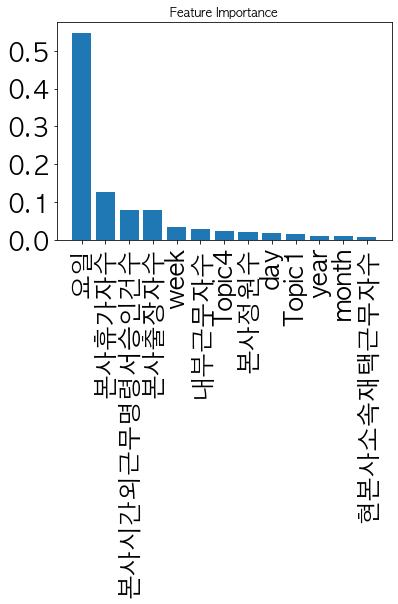

In [115]:
plt.title('Feature Importance')
plt.bar(range(train_lunch.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(train_lunch.shape[1]), train_lunch.columns[sorted_indices],rotation =90)
plt.xticks(color = "black", fontsize = 25)
plt.yticks(color = "black", fontsize = 25)
plt.tight_layout()
plt.show()

# 석식계 imporatance plot

In [116]:
importances = rf_dinner.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

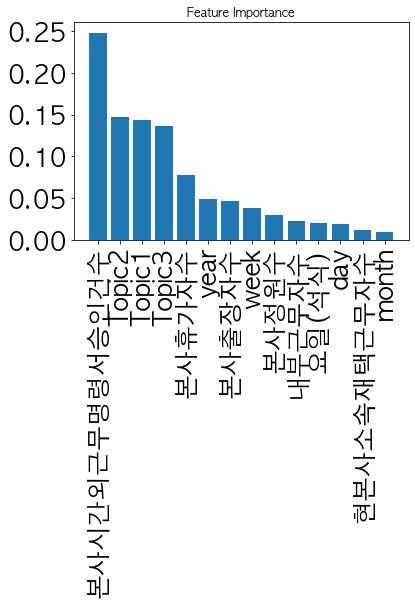

In [117]:
plt.title('Feature Importance')
plt.bar(range(train_dinner.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(train_dinner.shape[1]), train_dinner.columns[sorted_indices], rotation=90)
plt.xticks(color = "black", fontsize = 25)
plt.yticks(color = "black", fontsize = 25)
plt.tight_layout()
plt.show()

In [125]:
#submission = pd.read_csv('sample_submission.csv',encoding = 'utf-8')

In [126]:
#submission['중식계'] = pred1
#submission['석식계'] = pred2

In [127]:
#submission.to_csv('Topic02.csv', index=False)
#87

# Pycaret


In [134]:
train_lunch = train[['요일','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','중식계']]
test_lunch = test[['요일','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year']]

train_dinner = train[['요일(석식)','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','석식계','Topic1','Topic2','Topic3']]
test_dinner = test[['요일(석식)','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','Topic1','Topic2','Topic3']]



In [135]:
#중식 모델
reg = setup(data=train_lunch,
            target='중식계',
            numeric_imputation = 'mean',
            normalize = True,
            fold =10,
            feature_selection = True,
            silent= True,
           session_id = 7163)

,Description,Value
0,session_id,7163
1,Target,중식계
2,Original Data,"(1205, 12)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 30)"


In [136]:
best_model = compare_models(n_select=2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,66.1553,7885.9122,88.4484,0.8197,0.1083,0.0796,0.6610
gbr,Gradient Boosting Regressor,69.9501,8798.8255,93.3904,0.7991,0.1147,0.0847,0.0650
xgboost,Extreme Gradient Boosting,72.6379,9444.9909,96.7604,0.7847,0.1192,0.0876,0.4430
ridge,Ridge Regression,72.8376,9496.9586,96.9955,0.7837,0.1199,0.0879,0.0120
lr,Linear Regression,72.9196,9505.0784,97.0295,0.7835,0.1196,0.0879,0.0100
br,Bayesian Ridge,72.9635,9517.9593,97.1102,0.7831,0.1205,0.0883,0.0090
lightgbm,Light Gradient Boosting Machine,73.3788,9515.9195,97.2313,0.7824,0.1214,0.0889,0.1290
huber,Huber Regressor,72.3577,9610.0605,97.5402,0.7812,0.1211,0.0871,0.0260
lasso,Lasso Regression,73.6962,9649.7555,97.8529,0.7801,0.1223,0.0896,0.0090
rf,Random Forest Regressor,72.1515,9726.0830,98.4072,0.7773,0.1216,0.0880,0.2100


In [137]:
blended_l = blend_models(estimator_list = best_model, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)
pred_esb_l = predict_model(final_model_l, test_lunch)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,60.3398,6441.9575,80.2618,0.8285,0.0992,0.0743
1,64.5579,7749.3747,88.0305,0.8371,0.1181,0.0821
2,66.4412,8474.9174,92.0593,0.8248,0.1058,0.0757
3,70.6748,8685.2557,93.1947,0.8129,0.1076,0.0827
4,71.4570,8745.6650,93.5183,0.8017,0.1198,0.0890
Mean,66.6941,8019.4341,89.4129,0.8210,0.1101,0.0807
SD,4.0874,864.8189,4.9762,0.0124,0.0078,0.0053


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,60.7103,6277.9408,79.2335,0.8476,0.0982,0.0746


1)cat 66.15 voting 60.71  
2)cat 66.32 votung 60.88 > 중석식요일평균  
3)cat 65.97 voting 60.76 > 중식요일평균만



In [138]:
cat_lunch = create_model('catboost', fold =10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,62.7170,6307.7119,79.4211,0.8350,0.0968,0.0769
1,63.0923,6863.7592,82.8478,0.8110,0.1064,0.0790
2,66.6436,7963.9858,89.2412,0.8334,0.1325,0.0918
3,65.6643,8570.6812,92.5780,0.8167,0.1011,0.0724
4,63.9425,7112.0085,84.3327,0.8505,0.1000,0.0737
5,61.7052,7553.0876,86.9085,0.8433,0.0982,0.0694
6,75.6606,10431.8119,102.1362,0.7682,0.1231,0.0916
7,61.4198,6418.4207,80.1150,0.8637,0.0822,0.0660
8,66.2160,7089.4218,84.1987,0.8619,0.1149,0.0833
9,74.4920,10548.2334,102.7046,0.7129,0.1279,0.0921


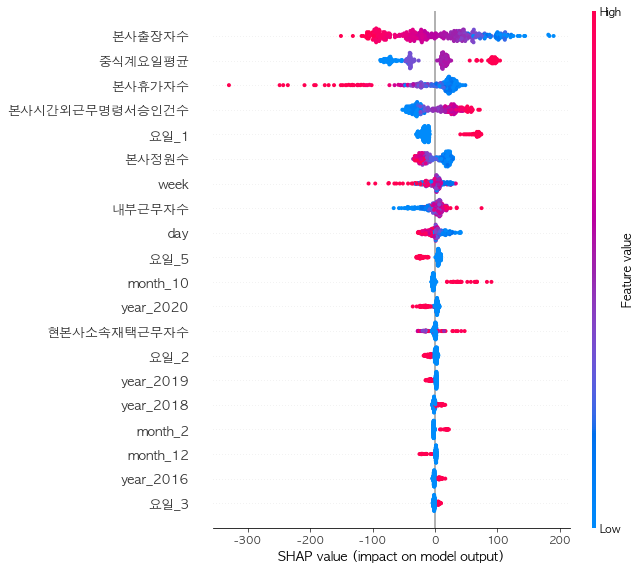

In [66]:
interpret_model(cat_lunch)

In [139]:
pred_esb_l = predict_model(final_model_l, test_lunch)

In [140]:
pred_esb_l['Label']

0      979.272438
1      923.098030
2      623.794579
3     1235.594760
4     1016.482323
5      988.902593
6      950.031166
7      702.082665
8     1280.205468
9     1070.968675
10     854.368178
11    1282.053899
12    1107.053346
13    1057.805993
14     904.369765
15     692.344306
16    1245.346187
17    1039.659035
18     932.396494
19     879.106194
20     621.266088
21    1077.030255
22    1009.386558
23     935.056652
24     694.943654
25    1305.389457
26    1135.810307
27    1023.836092
28     927.336624
29     703.823041
30    1260.958202
31    1029.755301
32    1022.338795
33     906.440086
34     664.437853
35    1223.758094
36     979.125613
37     902.043100
38     835.096551
39     608.258824
40    1217.359824
41     989.857922
42     956.141765
43     810.513392
44     643.539847
45    1211.689738
46     994.907602
47     976.978471
48     896.888950
49     645.786827
Name: Label, dtype: float64

In [73]:
submission = pd.read_csv('sample_submission.csv',encoding = 'utf-8')

In [141]:
submission['중식계'] = pred_esb_l['Label']
submission.head()

,일자,중식계,석식계
0,2021-01-27,979.272438,360.854222
1,2021-01-28,923.098030,418.865981
2,2021-01-29,623.794579,265.822370
3,2021-02-01,1235.594760,531.599525
4,2021-02-02,1016.482323,439.288863


In [122]:
#석식계
reg = setup(data=train_dinner,
            target='석식계',
            numeric_imputation = 'mean',
            normalize = True,
            fold =10,
            feature_selection = True,
            silent= True,
           session_id = 7198)

,Description,Value
0,session_id,7198
1,Target,석식계
2,Original Data,"(1205, 15)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 32)"


In [123]:
best_model2 = compare_models(n_select = 2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,47.1071,4478.6016,65.6348,0.7692,0.6776,0.1093,1.2270
lightgbm,Light Gradient Boosting Machine,49.1351,4722.7384,67.2427,0.7581,0.5700,0.1151,0.2590
rf,Random Forest Regressor,48.7583,4827.6495,67.7832,0.7553,0.4366,0.1164,0.2640
et,Extra Trees Regressor,49.1312,4944.3732,69.2142,0.7430,0.5554,0.1136,0.2140
gbr,Gradient Boosting Regressor,49.9428,5183.0661,70.6184,0.7312,0.6532,0.1153,0.0830
xgboost,Extreme Gradient Boosting,52.8099,5485.7883,72.8584,0.7201,0.6647,0.1200,0.6090
ada,AdaBoost Regressor,61.7744,6938.7829,82.7062,0.6382,0.8431,0.1405,0.0600
ridge,Ridge Regression,65.0473,8096.9465,89.5005,0.5849,1.0368,0.1317,0.0090
br,Bayesian Ridge,64.9566,8107.4053,89.5763,0.5844,1.0377,0.1320,0.0090
lr,Linear Regression,65.1167,8110.1113,89.5665,0.5842,1.0368,0.1316,0.0120


In [124]:
blended_d = blend_models(estimator_list = best_model2, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
pred_esb_d = predict_model(final_model_d, test_dinner)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,47.3899,3904.1087,62.4829,0.7879,0.7346,0.1146
1,43.3127,3111.5238,55.7810,0.8182,0.5395,0.1065
2,50.2168,5255.4658,72.4946,0.7354,0.7192,0.1233
3,53.4480,6342.5424,79.6401,0.7317,0.7717,0.1247
4,43.9087,3738.5766,61.1439,0.8085,0.8075,0.0882
Mean,47.6552,4470.4435,66.3085,0.7764,0.7145,0.1115
SD,3.8232,1168.2501,8.5806,0.0363,0.0927,0.0133


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,45.0687,3610.8553,60.0904,0.8047,0.5784,0.1123


1)cat 53.38 voting 50.62  
2)cat 53.94 voting 50.91 > 중식계요일평균만 추가  
3)cat 47.41 voting 45.06.> Topic 추가  

>현재의 변수들은 중식계 위주로 설명력이 높다, 그렇지만 석식계에 대한 변수들의 설명력이 낮으므로 이를 보완하는 파생변수 생성 필요  
>이후의 topicmodeling을 통해서 설명력을 높힐 수 있었다.  

In [125]:
cat_dinner = create_model('catboost', fold =10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,48.2871,4677.7348,68.3940,0.6478,0.1777,0.1261
1,46.6081,3597.7310,59.9811,0.8417,1.0767,0.0975
2,35.2222,2283.7781,47.7889,0.8346,0.1908,0.0852
3,47.3149,3637.3559,60.3105,0.8176,0.7729,0.1205
4,45.2942,5270.2388,72.5964,0.7205,0.9313,0.0946
5,53.9081,5367.8814,73.2658,0.7448,0.6489,0.1462
6,63.0560,9263.0571,96.2448,0.6236,0.8853,0.1506
7,42.5083,2704.8787,52.0084,0.8792,0.6071,0.0942
8,42.9772,3217.6271,56.7241,0.8472,0.6941,0.0912
9,45.8946,4765.7335,69.0343,0.7349,0.7914,0.0871


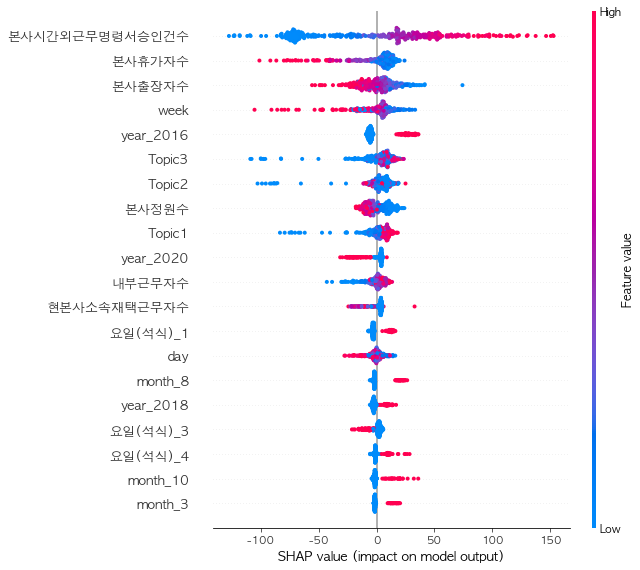

In [126]:
interpret_model(cat_dinner)

In [127]:
pred_esb_d = predict_model(final_model_d, test_dinner)

In [128]:
pred_esb_d['Label']

0     360.854222
1     418.865981
2     265.822370
3     531.599525
4     439.288863
5     404.785621
6     437.904023
7     370.892014
8     625.648272
9     525.992907
10    166.242658
11    689.524039
12    625.745906
13    441.614496
14    496.184671
15    373.551407
16    659.843665
17    631.428442
18    409.939096
19    513.643236
20    321.253122
21    645.956416
22    467.150585
23    564.988591
24    414.617355
25    669.769855
26    652.909674
27    463.955843
28    552.093554
29    357.014345
30    704.958062
31    569.399057
32    457.544764
33    474.255981
34    328.461648
35    628.122984
36    599.798432
37    408.099554
38    477.063167
39    313.922866
40    632.061736
41    589.164273
42    431.135677
43    434.252101
44    283.853834
45    601.417602
46    569.976110
47    439.945363
48    463.050427
49    296.474077
Name: Label, dtype: float64

In [129]:
submission = pd.read_csv('sample_submission.csv',encoding = 'utf-8')

In [142]:
submission['석식계'] = pred_esb_d['Label']
submission

,일자,중식계,석식계
0,2021-01-27,979.272438,360.854222
1,2021-01-28,923.098030,418.865981
2,2021-01-29,623.794579,265.822370
3,2021-02-01,1235.594760,531.599525
4,2021-02-02,1016.482323,439.288863
5,2021-02-03,988.902593,404.785621
6,2021-02-04,950.031166,437.904023
7,2021-02-05,702.082665,370.892014
8,2021-02-08,1280.205468,625.648272
9,2021-02-09,1070.968675,525.992907


In [143]:
submission.to_csv('RRRBaseline+dnTopic.csv', index=False)

# Autoviml

In [ ]:
from autoviml.Auto_ViML import Auto_ViML

In [255]:
target = '중식계'
m, feats, trainm, testm = Auto_ViML(train_lunch, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',
                            feature_reduction=True,
                             Boosting_Flag=True, Binning_Flag=False,
                            Add_Poly=False, Stacking_Flag=True,Imbalanced_Flag=False,
                            verbose=2)

##############  D A T A   S E T  A N A L Y S I S  #######################
Training Set Shape = (1205, 13)
    Training Set Memory Usage = 0.12 MB
Test Set Shape = (50, 15)
    Test Set Memory Usage = 0.01 MB
Single_Label Target: ['중식계']
No shuffling of data set before training...
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
Data Set Shape: 1205 rows, 12 cols
Data Set columns info:
* 요일: 0 nulls, 5 unique vals, most common: {4: 244, 1: 241}
* 휴가비율: 0 nulls, 1100 unique vals, most common: {0.026365348399246705: 3, 0.025423728813559324: 3}
* 출장비율: 0 nulls, 1113 unique vals, most common: {0.10621669626998224: 3, 0.09874723655121592: 3}
* 재택근무비율: 0 nulls, 193 unique vals, most common: {0.0: 988, 0.006779661016949152: 3}
* 내부근무자수: 0 nulls, 522 unique vals, most common: {2334.0: 9, 2330.0: 8}
* 본사출장자수: 0 nulls, 194 unique vals, m

TypeError: cannot unpack non-iterable NoneType object